# Models without tweets features

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.externals import joblib
from sklearn import model_selection, linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

# visualization library
import seaborn as sns
sns.set(style="white", color_codes=True)
sns.set_context(rc={"font.family":'sans',"font.size":24,"axes.titlesize":24,"axes.labelsize":24})   

# import matplotlib and allow it to plot inline
import matplotlib.pyplot as plt
%matplotlib inline

# seaborn can generate several warnings, we ignore them
import warnings 
warnings.filterwarnings("ignore")

import missingno as msno
import math

### Load, join and clean datasets

In [2]:
#targets:
#    0: porn
#    1: propaganda
#    2: spam
#    3: fake followers
#    4: genuine accounts

porn = pd.read_csv('data/porn/users.csv', encoding='utf-8-sig')
porn['target'] = 0

propaganda = pd.read_csv('data/propaganda/users.csv', encoding='utf-8-sig')
propaganda['target'] = 1

spam = pd.read_csv('data/spam/users.csv', encoding='utf-8-sig')
spam['target'] = 2

fake_followers = pd.read_csv('data/fake_followers/users.csv', encoding='utf-8-sig')
fake_followers['target'] = 3
chosen_idx = np.random.choice(8825, replace=False, size=5000)
fake_followers = fake_followers.iloc[chosen_idx]

genuine = pd.read_csv('data/genuine/users.csv', encoding='utf-8-sig')
genuine['target'] = 4

frames = [porn, propaganda, spam, fake_followers, genuine]
users = pd.concat(frames, ignore_index=True)

## Visualize missing values

### Full

In [3]:
for c in users.columns:
    print(c)

contributors_enabled
created_at
default_profile
default_profile_image
description
favourites_count
follow_request_sent
followers_count
following
friends_count
geo_enabled
id
is_translator
lang
listed_count
location
name
notifications
profile_background_color
profile_background_image_url
profile_background_image_url_https
profile_background_tile
profile_image_url
profile_image_url_https
profile_link_color
profile_sidebar_border_color
profile_sidebar_fill_color
profile_text_color
profile_use_background_image
protected
screen_name
statuses_count
target
time_zone
url
utc_offset
verified


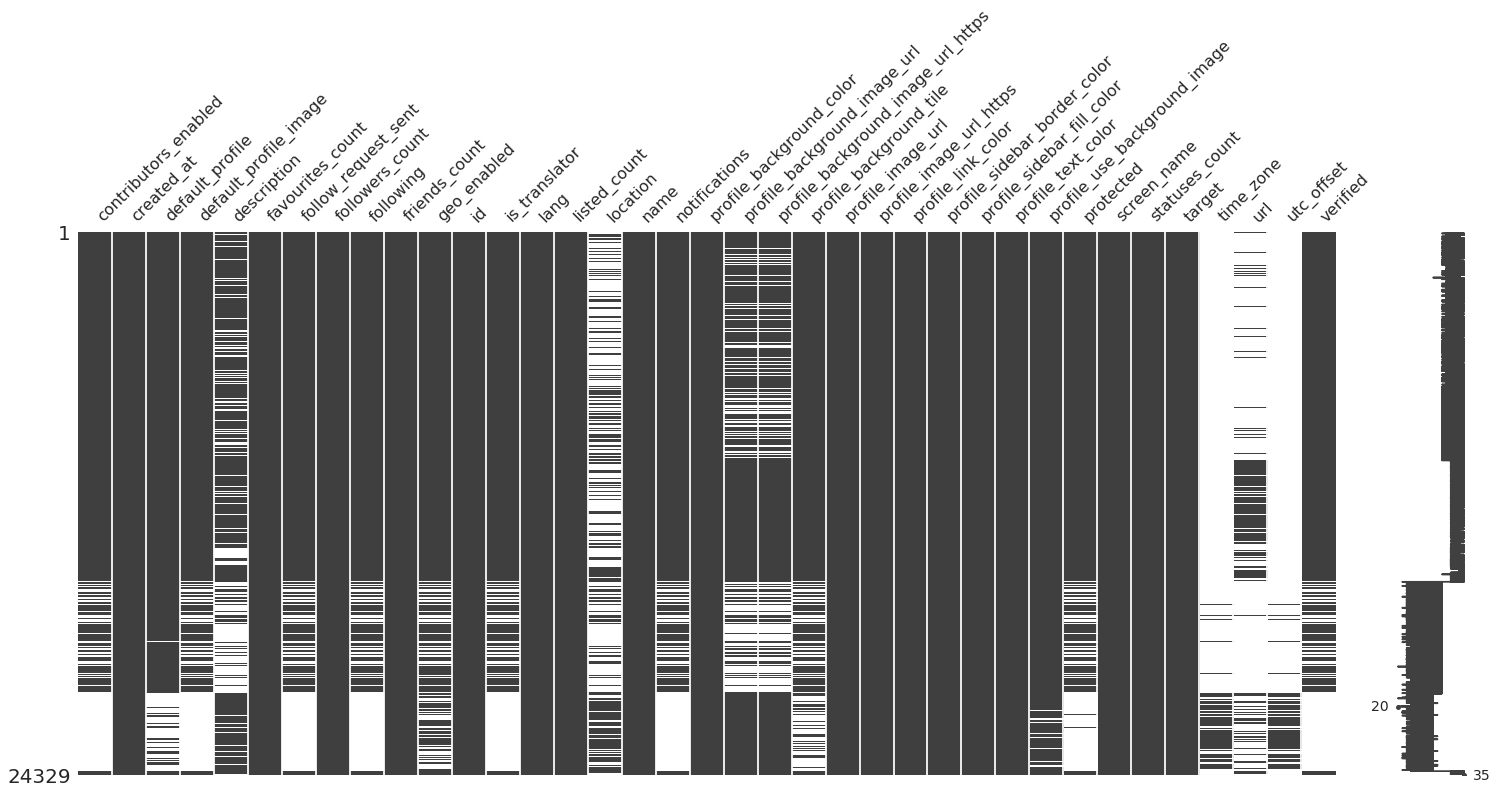

In [3]:
msno.matrix(users)

### Porn Bots

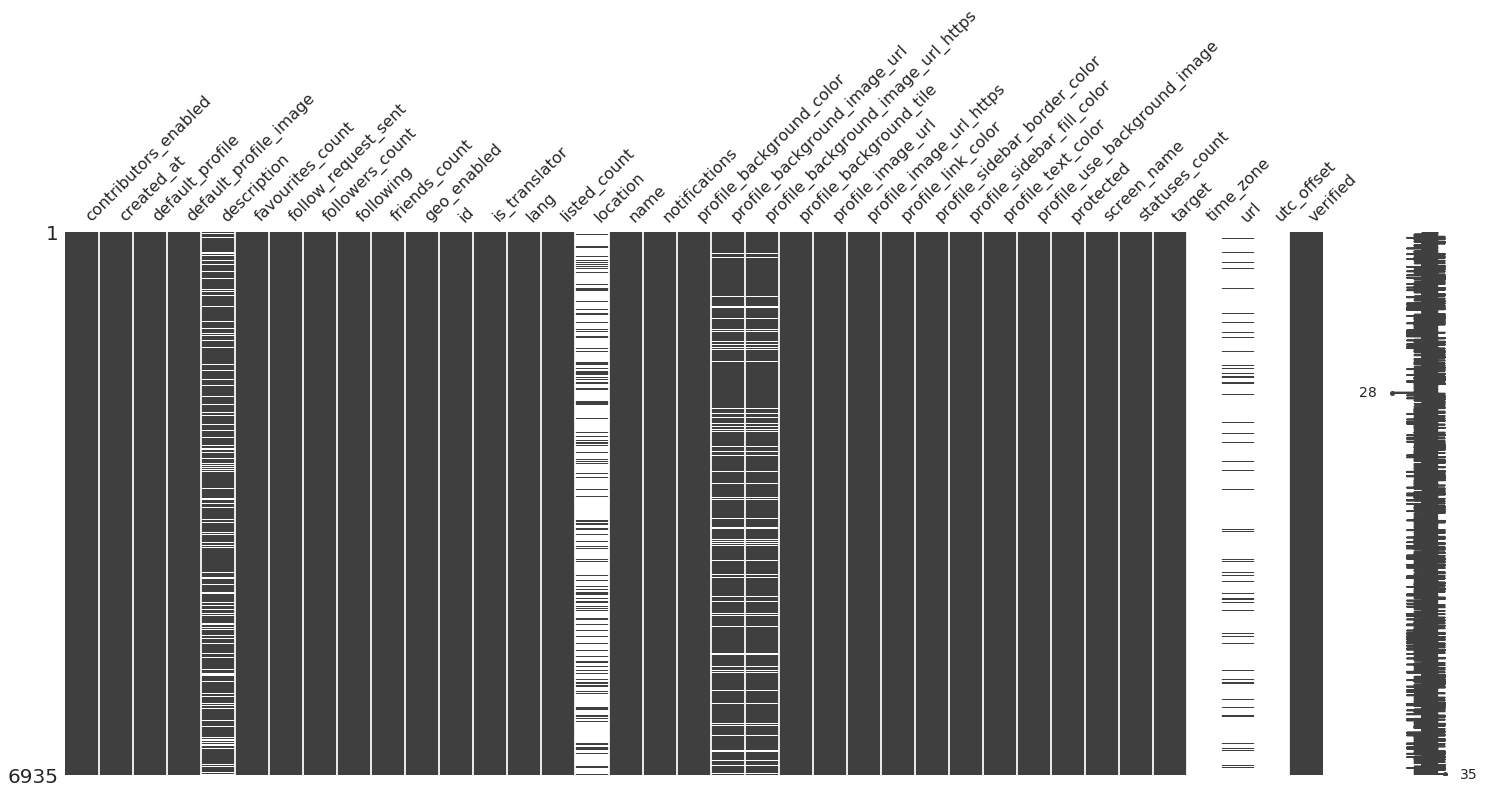

In [4]:
msno.matrix(users[users.target==0])

### Propaganda Bots

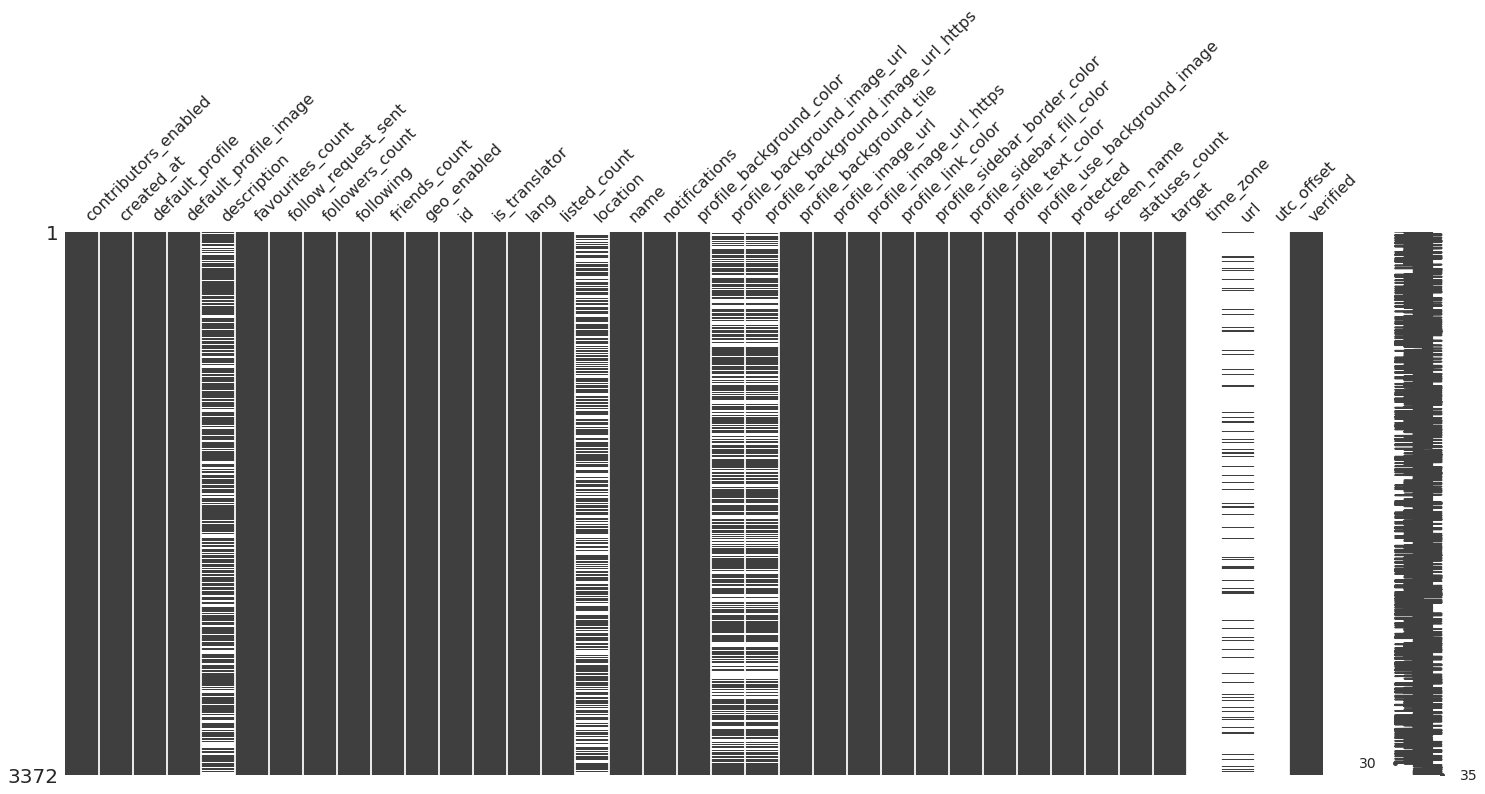

In [5]:
msno.matrix(users[users.target==1])

### Spam Bots

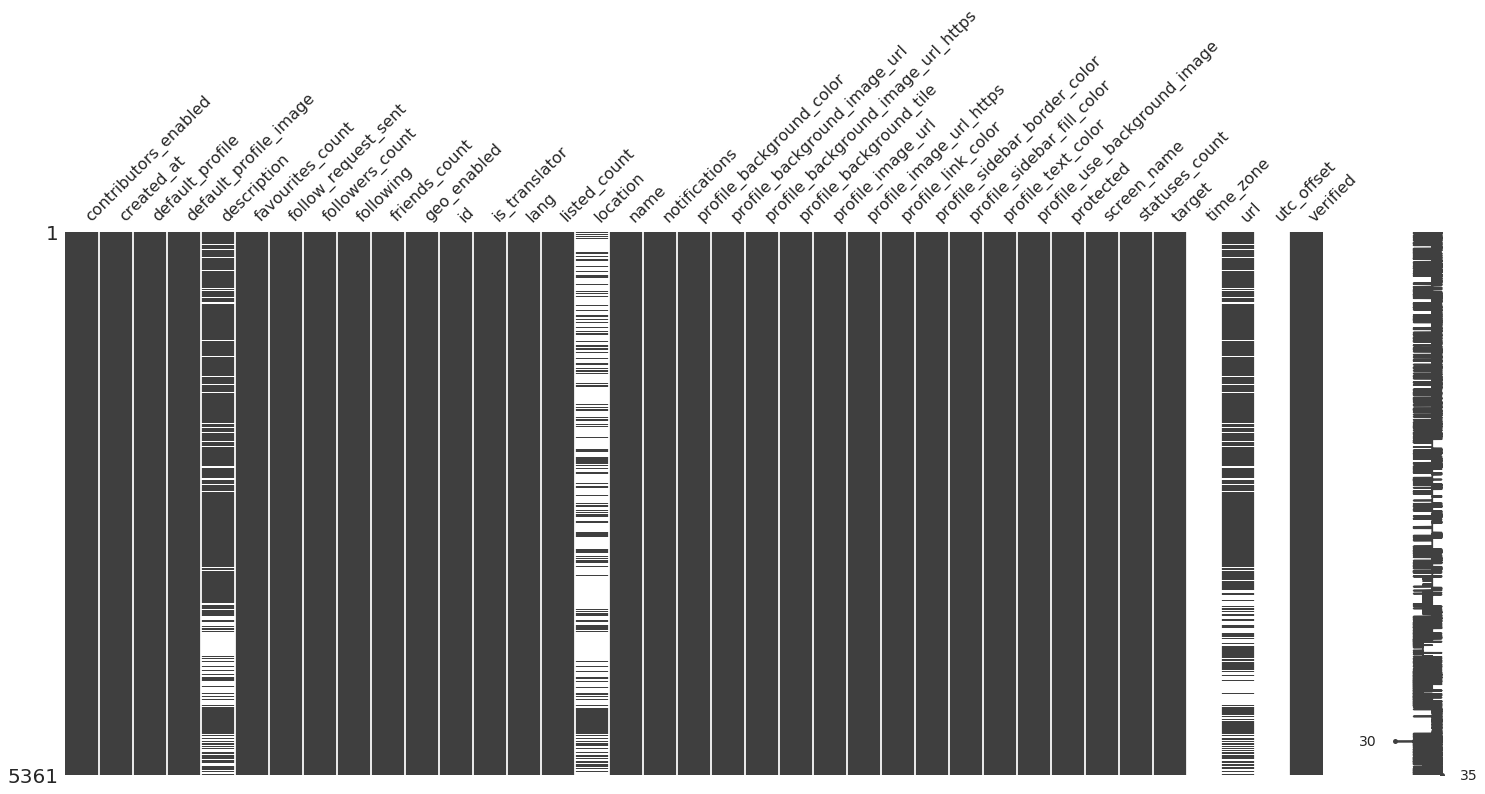

In [6]:
msno.matrix(users[users.target==2])

### Fake Followers

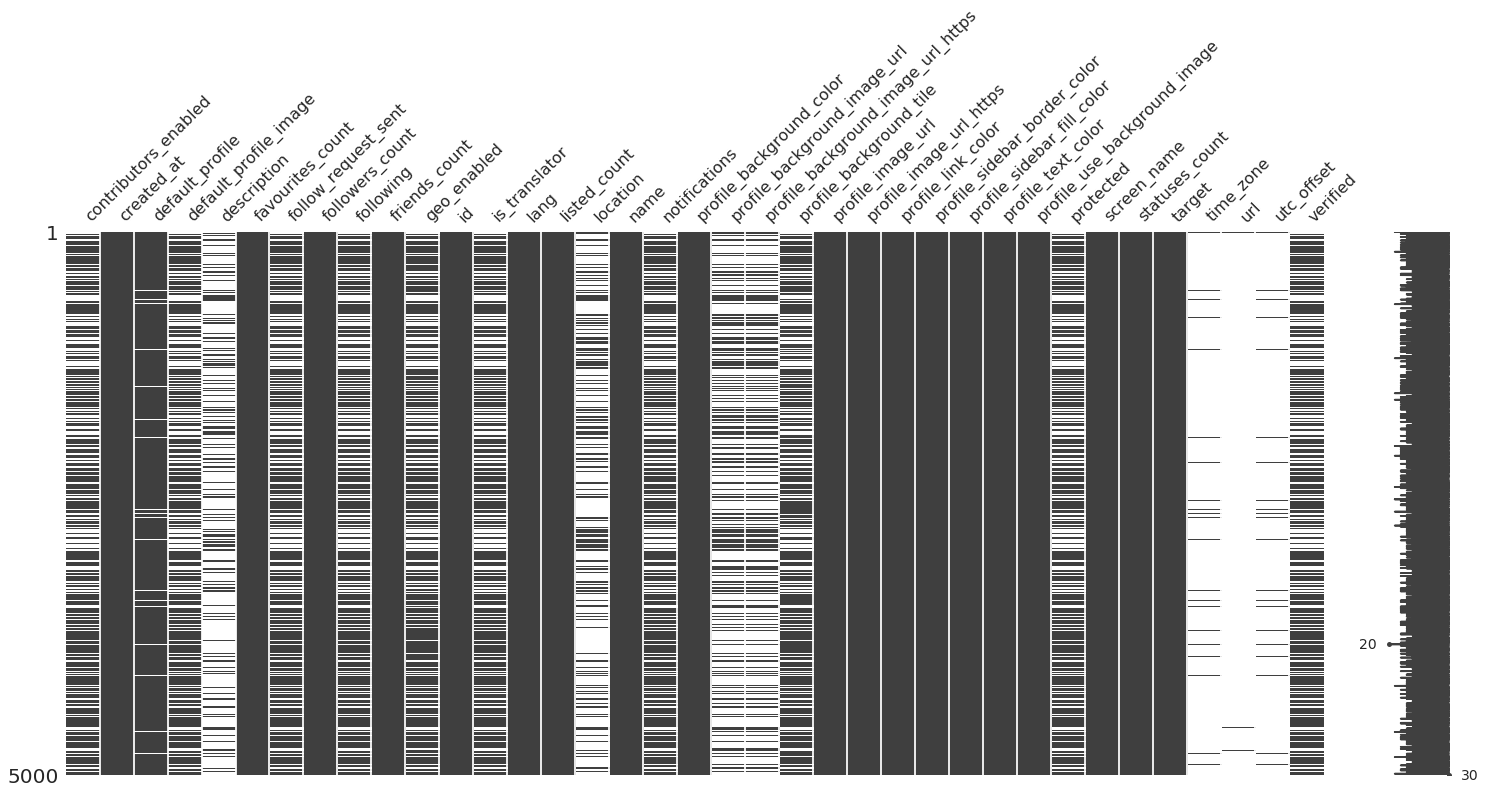

In [7]:
msno.matrix(users[users.target==3])

### Genuine Accounts

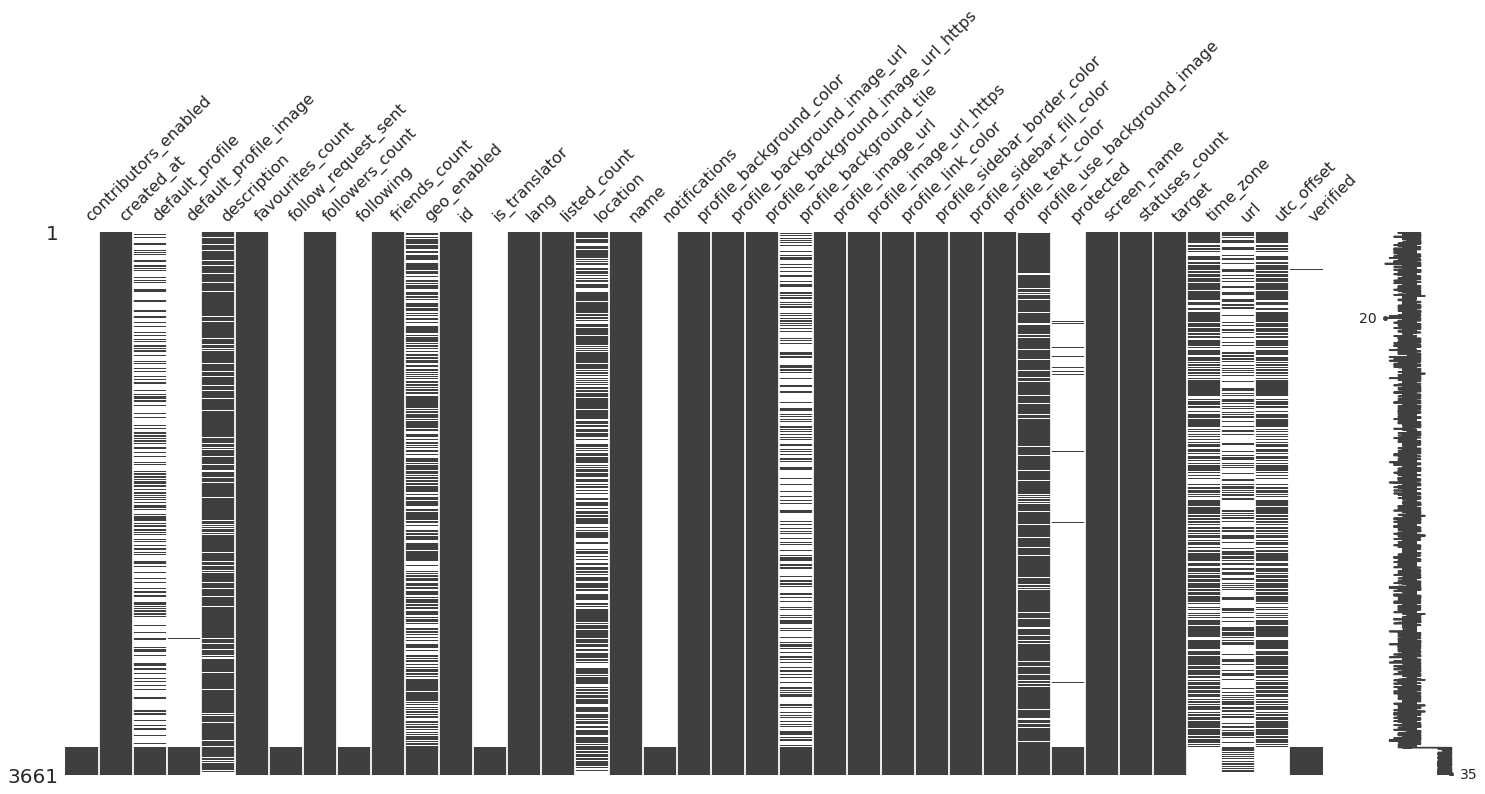

In [8]:
msno.matrix(users[users.target==4])

### remove attributes with a lot of missing values 

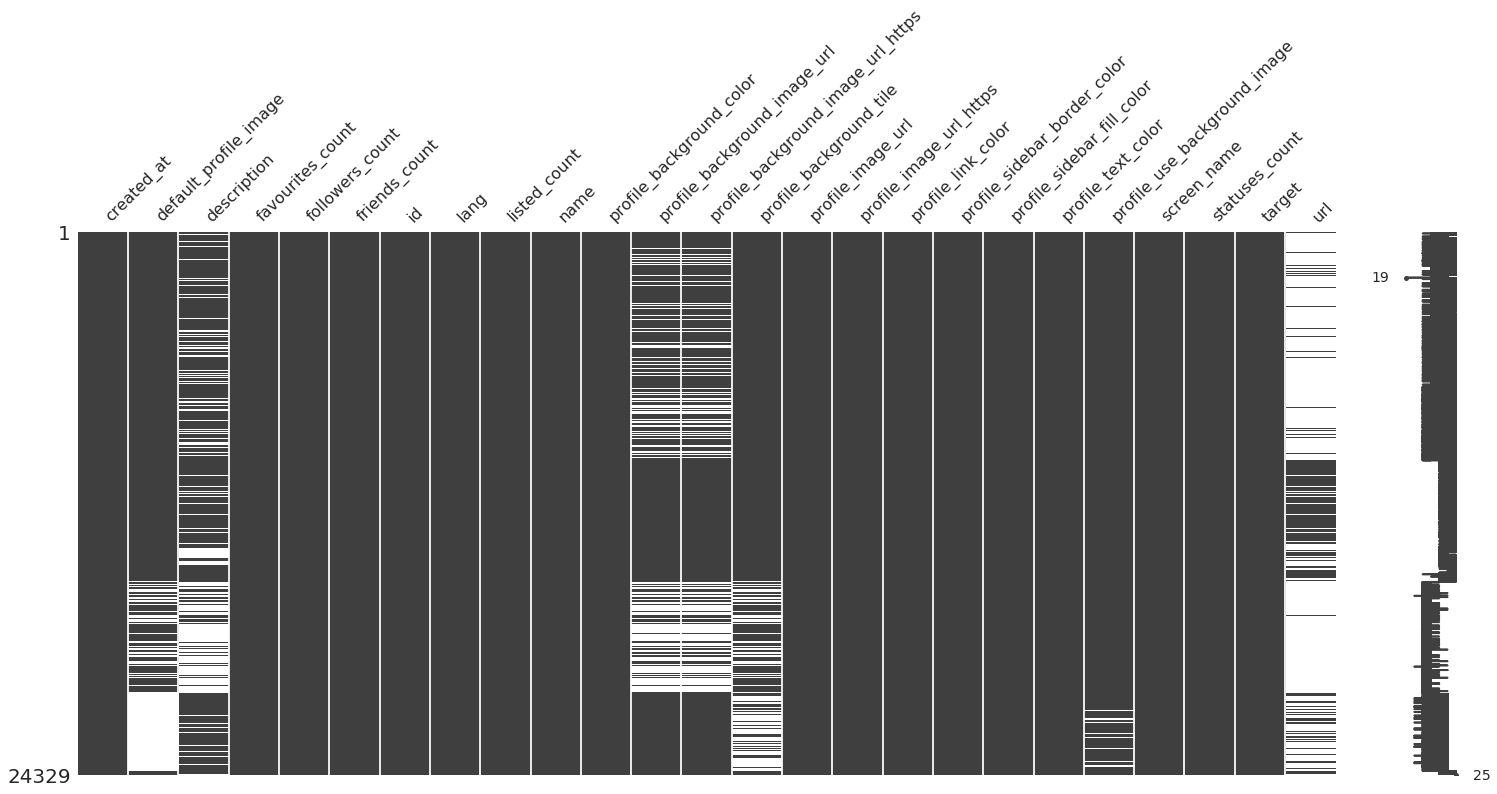

In [10]:
users = users.drop(columns=['default_profile', 'location', 'verified', 'contributors_enabled', 'follow_request_sent', 'following', 'geo_enabled', 'is_translator', 'notifications', 'time_zone', 'utc_offset', 'protected'], axis=1)
msno.matrix(users)

### Remove useless attributes

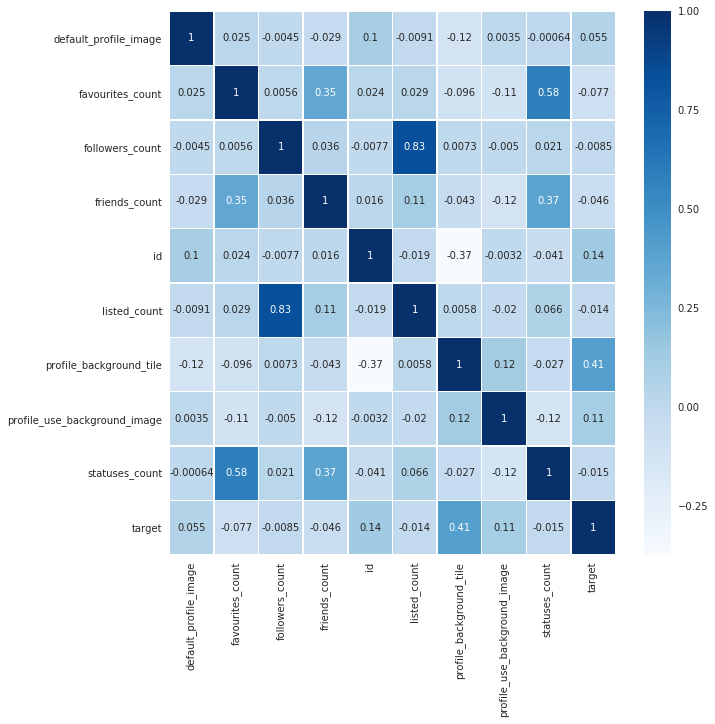

In [11]:
fig, ax = plt.subplots(figsize=(10,10))
cov=users.corr(method='pearson')
sns.heatmap(cov,annot=True,cmap="Blues",linewidths=.5, ax=ax)

In [12]:
users = users.drop(columns=['id', 'screen_name'], axis=1)

### Fill missing fields

Distribution of missing values

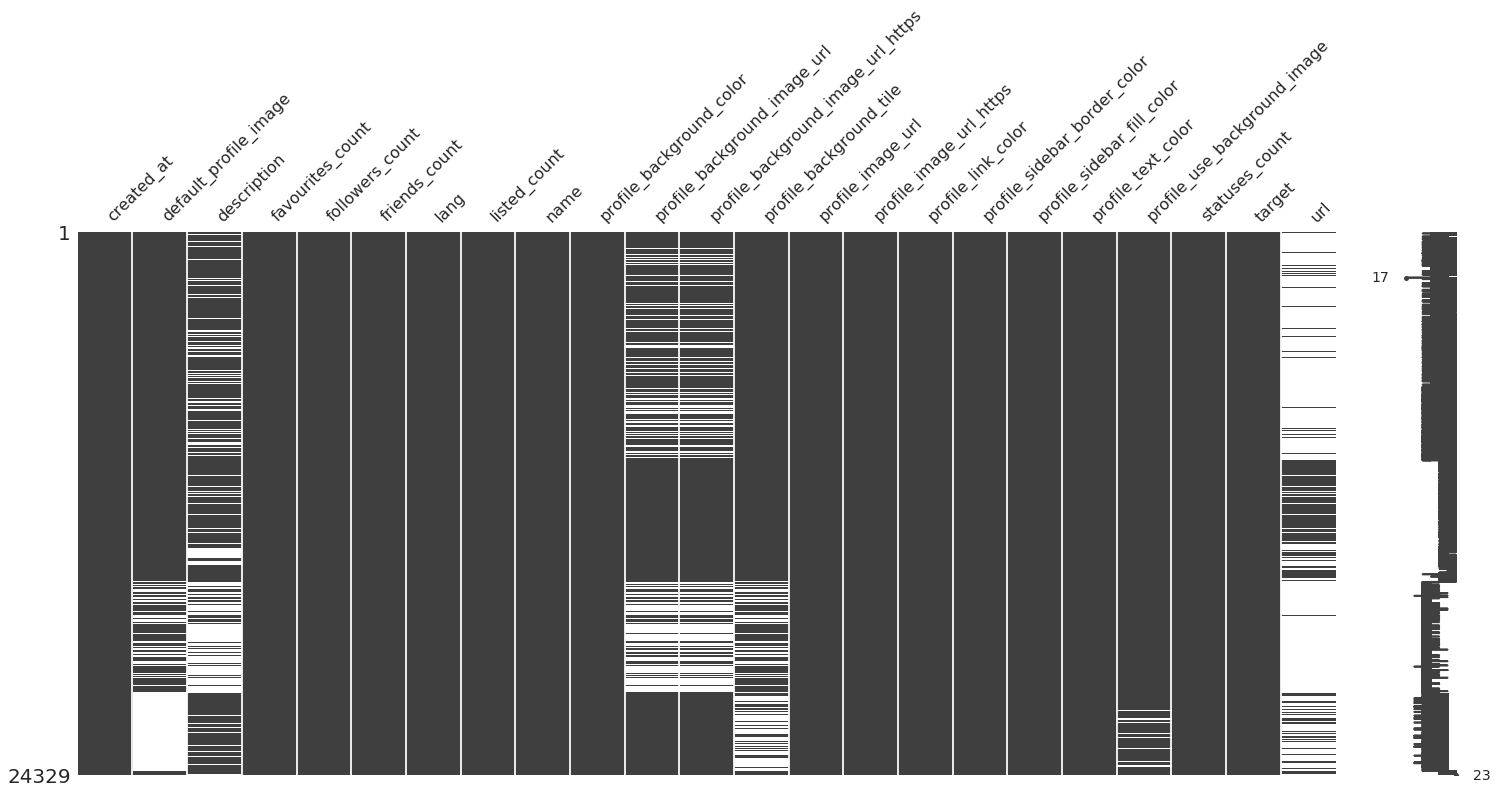

In [13]:
msno.matrix(users)

Fill missing values

In [14]:
users['default_profile_image'].describe()

count    18996.000000
mean         0.048852
std          0.215565
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default_profile_image, dtype: float64

In [15]:
print(users[users.target == 0]['default_profile_image'].isnull().values.any())
print(users[users.target == 1]['default_profile_image'].isnull().values.any())
print(users[users.target == 2]['default_profile_image'].isnull().values.any())
print(users[users.target == 3]['default_profile_image'].isnull().values.any())
print(users[users.target == 4]['default_profile_image'].isnull().values.any())

False
False
False
True
True


In [16]:
users.loc[users.target == 3,'default_profile_image'].describe()

count    3128.000000
mean        0.061701
std         0.240650
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: default_profile_image, dtype: float64

In [17]:
users.loc[users.target == 3,'default_profile_image'] = np.nan_to_num(users[users.target == 3]['default_profile_image'])

In [18]:
users.loc[users.target == 4,'default_profile_image'].describe()

count    200.000000
mean       0.095000
std        0.293951
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: default_profile_image, dtype: float64

In [19]:
users.loc[users.target == 4,'default_profile_image'] = np.nan_to_num(users[users.target == 4]['default_profile_image'])

In [20]:
users['description'] = users['description'].fillna('')

In [21]:
users['description'] = users['description'].apply(lambda x: len(x))

In [22]:
users['description'].describe()

count    24329.000000
mean        52.855604
std         51.228417
min          0.000000
25%          0.000000
50%         44.000000
75%         83.000000
max        175.000000
Name: description, dtype: float64

In [23]:
users['lang'].isnull().values.any()

False

In [24]:
users['profile_background_color'].isnull().values.any()

False

In [25]:
users['profile_background_color'].isnull().values.any()

False

In [26]:
users['profile_background_tile'].isnull().values.any()

True

In [27]:
print(users[users.target == 0]['profile_background_tile'].isnull().values.any())
print(users[users.target == 1]['profile_background_tile'].isnull().values.any())
print(users[users.target == 2]['profile_background_tile'].isnull().values.any())
print(users[users.target == 3]['profile_background_tile'].isnull().values.any())
print(users[users.target == 4]['profile_background_tile'].isnull().values.any())

False
False
False
True
True


In [28]:
users.loc[users.target == 3, 'profile_background_tile'].describe()

count    3221.000000
mean        0.029804
std         0.170074
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: profile_background_tile, dtype: float64

In [29]:
users.loc[users.target == 3,'profile_background_tile'] = np.nan_to_num(users[users.target == 3]['profile_background_tile'])

In [30]:
users.loc[users.target == 4, 'profile_background_tile'].describe()

count    1494.000000
mean        0.901606
std         0.297946
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: profile_background_tile, dtype: float64

In [31]:
users.loc[users.target == 4,'profile_background_tile'] = np.nan_to_num(users[users.target == 4]['profile_background_tile'])

In [32]:
users['profile_link_color'].isnull().values.any()

False

In [33]:
users['profile_sidebar_border_color'].isnull().values.any()

False

In [34]:
users['profile_sidebar_fill_color'].isnull().values.any()

False

In [35]:
users['profile_text_color'].isnull().values.any()

False

In [36]:
users['profile_use_background_image'].isnull().values.any()

True

In [37]:
print(users[users.target == 0]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 1]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 2]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 3]['profile_use_background_image'].isnull().values.any())
print(users[users.target == 4]['profile_use_background_image'].isnull().values.any())

False
False
False
True
True


In [38]:
users.loc[users.target==3,'profile_use_background_image'].describe()

count    4995.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: profile_use_background_image, dtype: float64

In [39]:
users.loc[users.target == 3,'profile_use_background_image'] = np.nan_to_num(users[users.target == 3]['profile_use_background_image'])

In [40]:
users.loc[users.target==4,'profile_use_background_image'].describe()

count    3271.000000
mean        0.992357
std         0.087102
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: profile_use_background_image, dtype: float64

In [41]:
users.loc[users.target == 4,'profile_use_background_image'] = np.nan_to_num(users[users.target == 4]['profile_use_background_image'])

In [42]:
print(users[users.target == 0]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 1]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 2]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 3]['profile_background_image_url'].isnull().values.any())
print(users[users.target == 4]['profile_background_image_url'].isnull().values.any())

True
True
True
True
True


In [43]:
users['profile_background_image_url'].describe()

count                                                19264
unique                                                1762
top       http://abs.twimg.com/images/themes/theme1/bg.png
freq                                                 13584
Name: profile_background_image_url, dtype: object

In [44]:
users['profile_background_image_url'] = users['profile_background_image_url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [45]:
users['profile_background_image_url_https'].isnull().values.any()

True

In [46]:
users['profile_background_image_url_https'].describe()

count                                                 19264
unique                                                 1769
top       https://abs.twimg.com/images/themes/theme1/bg.png
freq                                                  13584
Name: profile_background_image_url_https, dtype: object

In [47]:
users['profile_background_image_url_https'] = users['profile_background_image_url_https'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [48]:
users['url'].describe()

count                       6621
unique                      6070
top       http://t.co/lGxZ0Tq4gs
freq                          57
Name: url, dtype: object

In [49]:
users['url'] = users['url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [50]:
users['profile_image_url'].describe()

count                                                 24326
unique                                                22576
top       http://abs.twimg.com/sticky/default_profile_im...
freq                                                    912
Name: profile_image_url, dtype: object

In [51]:
users['profile_image_url'] = users['profile_image_url'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [52]:
users['profile_image_url_https'].describe()

count                                                 24326
unique                                                22576
top       https://abs.twimg.com/sticky/default_profile_i...
freq                                                    912
Name: profile_image_url_https, dtype: object

In [53]:
users['profile_image_url_https'] = users['profile_image_url_https'].apply(lambda x: int(not(int(pd.isnull(x)))))

In [54]:
users['name'].isnull().values.any()

True

In [55]:
users['name'] = users['name'].fillna('')

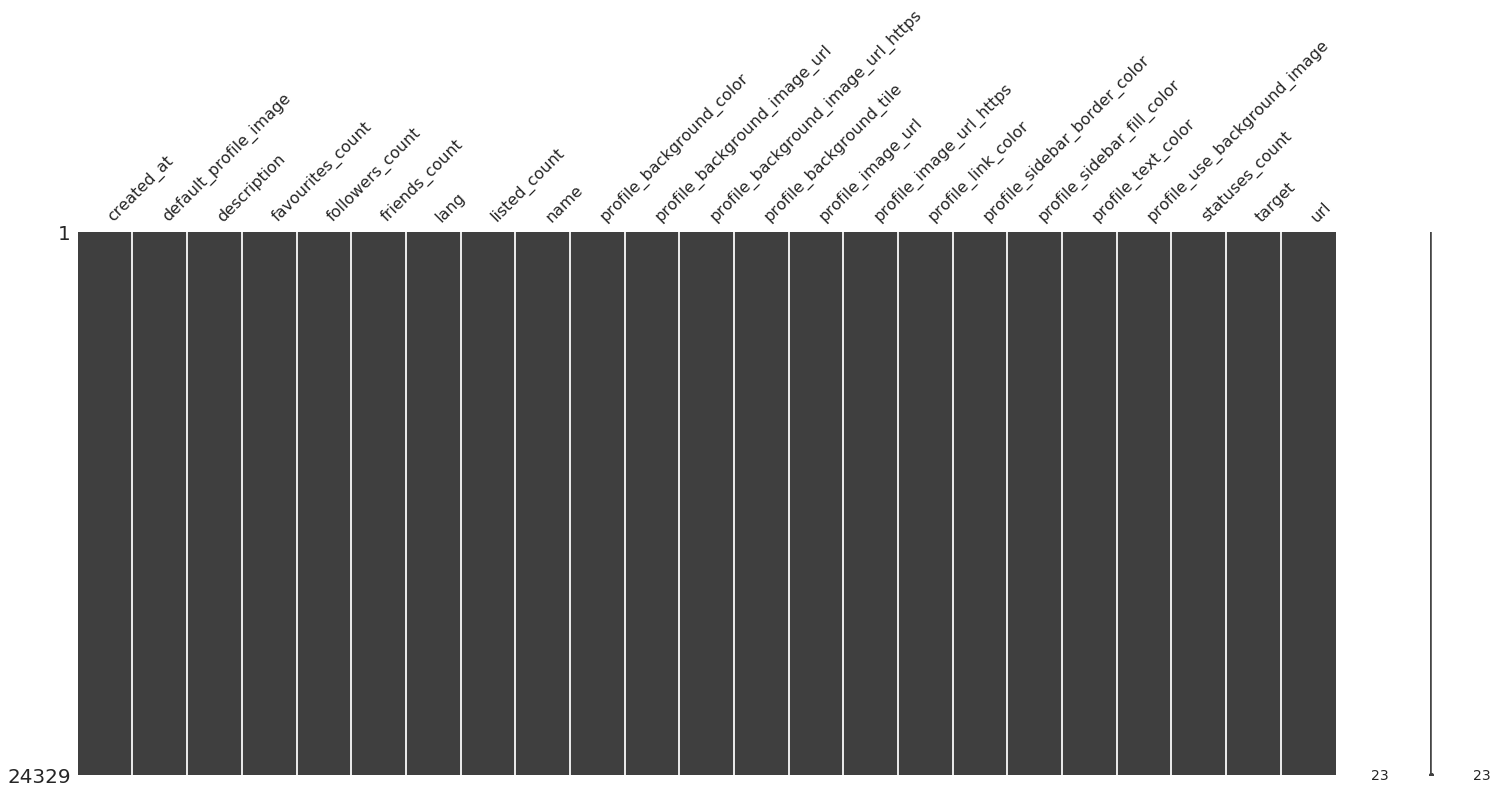

In [56]:
msno.matrix(users)

In [57]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_image_url,profile_image_url_https,profile_use_background_image,statuses_count,target,url
count,24329.000000,24329.000000,24329.000000,2.432900e+04,24329.000000,24329.000000,24329.000000,24329.000000,24329.000000,24329.000000,24329.000000,24329.000000,2.432900e+04,24329.000000,24329.000000
mean,0.038144,52.855604,6197.727732,6.877338e+03,1141.386946,39.806075,0.791812,0.791812,0.247030,0.999877,0.999877,0.946607,1.174468e+04,1.797772,0.272144
std,0.191547,51.228417,26772.060050,3.714788e+05,4845.216929,946.012863,0.406020,0.406020,0.431293,0.011104,0.011104,0.224821,4.270381e+04,1.430183,0.445073
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000e+01,145.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.100000e+01,0.000000,0.000000
50%,0.000000,44.000000,107.000000,3.500000e+01,221.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,9.600000e+01,2.000000,0.000000
75%,0.000000,83.000000,541.000000,2.260000e+02,649.000000,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,4.025000e+03,3.000000,1.000000
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.418488e+06,4.000000,1.000000


In [58]:
users.describe(exclude=[np.number])

,created_at,lang,name,profile_background_color,profile_link_color,profile_sidebar_border_color,profile_sidebar_fill_color,profile_text_color
count,24329,24329,24329,24329,24329,24329,24329,24329
unique,23399,46,22554,926,1452,431,674,711
top,2018-06-06 04:51:54,en,.,C0DEED,1DA1F2,C0DEED,DDEEF6,333333
freq,4,18661,10,13945,12378,15663,19695,21127


### Create model

### Drop non numeric features

In [59]:
users = users.drop(columns=['created_at', 'lang', 'name', 'profile_background_color', 'profile_image_url', 'profile_image_url_https', 'profile_link_color', 'profile_sidebar_border_color', 'profile_sidebar_fill_color', 'profile_text_color'], axis=1)

In [60]:
users.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,24329.000000,24329.000000,24329.000000,2.432900e+04,24329.000000,24329.000000,24329.000000,24329.000000,24329.000000,24329.000000,2.432900e+04,24329.000000,24329.000000
mean,0.038144,52.855604,6197.727732,6.877338e+03,1141.386946,39.806075,0.791812,0.791812,0.247030,0.946607,1.174468e+04,1.797772,0.272144
std,0.191547,51.228417,26772.060050,3.714788e+05,4845.216929,946.012863,0.406020,0.406020,0.431293,0.224821,4.270381e+04,1.430183,0.445073
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000e+01,145.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2.100000e+01,0.000000,0.000000
50%,0.000000,44.000000,107.000000,3.500000e+01,221.000000,0.000000,1.000000,1.000000,0.000000,1.000000,9.600000e+01,2.000000,0.000000
75%,0.000000,83.000000,541.000000,2.260000e+02,649.000000,2.000000,1.000000,1.000000,0.000000,1.000000,4.025000e+03,3.000000,1.000000
max,1.000000,175.000000,913239.000000,5.254102e+07,191706.000000,89208.000000,1.000000,1.000000,1.000000,1.000000,1.418488e+06,4.000000,1.000000


In [61]:
users.to_csv('data/full/baseline_dataset.csv')

In [62]:
target = 'target'
features = users.columns[users.columns!=target]

In [63]:
X = users[features]
y = users[target]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [65]:
# Fitting Random Forest Classification to the Training set
forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [66]:
# Fitting Logistic Regression
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Holdout score - forest

In [67]:
# Predicting the Test set results
y_pred = forest.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target     0    1     2     3    4
Actual Target                               
0                 1656   20    14     5   68
1                   30  721    24     0   86
2                    6   31  1217     5   53
3                    9    1     3  1226    1
4                   71   68    42     1  725


### Most important features

In [68]:
sorted(zip(map(lambda x: round(x, 2), forest.feature_importances_), X.columns), reverse=True)[:10]

[(0.36, 'favourites_count'),
 (0.21, 'statuses_count'),
 (0.09, 'followers_count'),
 (0.08, 'friends_count'),
 (0.06, 'url'),
 (0.05, 'profile_background_tile'),
 (0.05, 'description'),
 (0.04, 'listed_count'),
 (0.03, 'profile_background_image_url_https'),
 (0.02, 'profile_background_image_url')]

### Holdout score - logistic regression

In [69]:
# Predicting the Test set results
y_pred = logreg.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target     0    1     2     3    4
Actual Target                               
0                 1254  112   215    19  163
1                   29  673    80     0   79
2                    8   41  1229     5   29
3                    0    2    48  1189    1
4                   93  261   217     0  336


## KNN

In [70]:
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)
X_n = scaler.fit_transform(X)

In [71]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train_n, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [72]:
# Predicting the Test set results
y_pred = knn.predict(X_test_n)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target     0    1     2     3    4
Actual Target                               
0                 1512   39    50    84   78
1                   49  674    28    11   99
2                   43   24  1076    41  128
3                   77    0    66  1072   25
4                  138   69   132    88  480


## Cross Validation scores

In [73]:
from sklearn.model_selection import cross_val_score
forest = RandomForestClassifier(n_estimators = 6 , criterion = 'entropy', random_state = 42)
logreg = linear_model.LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=10)
svm = svm.SVC()
scores = []
scores.append(cross_val_score(forest, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(logreg, X, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(knn, X_n, y, cv=10, scoring='f1_macro').mean())
scores.append(cross_val_score(svm, X, y, cv=10, scoring='f1_macro').mean())

In [74]:
# Random forest  /  Logistic Regression  /  KNN  /  SVM
scores

[0.8870441844731024, 0.7590879209688355, 0.768053638528036, 0.3195545849348225]

## Test BotOrNot

In [134]:
len(users[users.target==0])

6919

In [135]:
chosen_idx = np.random.choice(14052, replace=False, size=3800)
bots = users.iloc[chosen_idx]
bots['target'] = 0

In [136]:
genuines = users[users.target == 4]
genuines['target'] = 1

In [137]:
frames = [bots, genuines]
bot_or_not_df = pd.concat(frames, ignore_index=True)

In [138]:
target = 'target'
features = bot_or_not_df.columns[bot_or_not_df.columns!=target]
X = bot_or_not_df[features]
y = bot_or_not_df[target]

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [140]:
scaler = MinMaxScaler()
X_train_n = scaler.fit_transform(X_train)
X_test_n = scaler.fit_transform(X_test)
X_n = scaler.fit_transform(X)

In [141]:
from sklearn.model_selection import cross_val_score
forest = RandomForestClassifier(n_estimators = 6, criterion = 'entropy', random_state = 42)
logreg = linear_model.LogisticRegression()
knn = KNeighborsClassifier(n_neighbors=5)
scores = []
scores.append(cross_val_score(forest, X, y, cv=10, scoring='f1').mean())
scores.append(cross_val_score(logreg, X, y, cv=10, scoring='f1').mean())
scores.append(cross_val_score(knn, X_n, y, cv=10, scoring='f1').mean())

In [142]:
scores

[0.90298319319549447, 0.54638638974358855, 0.83811582441920274]

In [194]:
# Fitting Random Forest Classification to the Training set
forest = RandomForestClassifier(n_estimators = 1, criterion = 'entropy', random_state = 42)
forest.fit(X_train, y_train)
# Predicting the Test set results
y_pred = forest.predict(X_test)
# Making the Confusion Matrix
print(pd.crosstab(y_test, y_pred, rownames=['Actual Target'], colnames=['Predicted Target']))

Predicted Target    0    1
Actual Target             
0                 884   88
1                  99  748


In [143]:
bots.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,3800.000000,3800.000000,3800.000000,3.800000e+03,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.0,3800.000000
mean,0.038684,62.814211,9772.864211,5.958372e+03,1580.338421,50.326316,0.863158,0.863158,0.303421,0.951316,14989.221316,0.0,0.307632
std,0.192867,47.984508,36332.448677,1.878057e+05,6086.143673,1252.536219,0.343726,0.343726,0.459796,0.215235,50830.043909,0.0,0.461574
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.000000,35.000000,7.000000,1.700000e+01,84.000000,0.000000,1.000000,1.000000,0.000000,1.000000,47.000000,0.0,0.000000
50%,0.000000,54.000000,195.000000,3.600000e+01,187.000000,0.000000,1.000000,1.000000,0.000000,1.000000,107.000000,0.0,0.000000
75%,0.000000,91.000000,630.250000,1.750000e+02,763.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3706.000000,0.0,1.000000
max,1.000000,164.000000,913239.000000,1.142709e+07,191706.000000,74384.000000,1.000000,1.000000,1.000000,1.000000,965547.000000,0.0,1.000000


In [144]:
genuines.describe()

,default_profile_image,description,favourites_count,followers_count,friends_count,listed_count,profile_background_image_url,profile_background_image_url_https,profile_background_tile,profile_use_background_image,statuses_count,target,url
count,3474.000000,3474.000000,3474.000000,3474.000000,3474.000000,3474.000000,3474.0,3474.0,3474.000000,3474.000000,3474.000000,3474.0,3474.000000
mean,0.003742,63.778066,4669.620322,1393.219632,633.242372,19.496546,1.0,1.0,0.376223,0.887737,16958.220207,1.0,0.364421
std,0.061067,50.882751,11527.566663,17216.664524,1600.962972,157.740969,0.0,0.0,0.484507,0.315735,30696.286104,0.0,0.481337
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,3.000000,1.0,0.000000
25%,0.000000,20.000000,261.250000,149.000000,169.000000,0.000000,1.0,1.0,0.000000,1.000000,1810.250000,1.0,0.000000
50%,0.000000,51.000000,1286.000000,341.000000,319.000000,2.000000,1.0,1.0,0.000000,1.000000,6609.000000,1.0,0.000000
75%,0.000000,106.750000,4727.000000,803.750000,635.750000,8.000000,1.0,1.0,1.000000,1.000000,19467.000000,1.0,1.000000
max,1.000000,160.000000,313954.000000,986837.000000,46310.000000,6166.000000,1.0,1.0,1.000000,1.000000,399555.000000,1.0,1.000000
